# Deep Food Image Classifier with ES(1+1)

**Author:** V. Harsha Vardhan Yellela  
**Course:** MCS-5993 Evolutionary Computing & Deep Learning  
**Institution:** Lawrence Technological University  
**Date:** 2025-11-09

**Description:**  
10-class food image classifier with out-of-scope detection. Baseline CNN training with ES(1+1) hyperparameter optimization.  
Built from scratch using Keras/TensorFlow with multi-GPU mixed-precision acceleration.

**Dataset:** 10 food classes in `dataset_simplified/` with train/val/test splits.

### Imports and configuration

In [1]:
import os
import random
import shutil
import json
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError:
        pass  # already initialized

tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_ROOT = Path(r"/home/har5ha/term_project/Dataset")
SRC_DIR = DATA_ROOT / "dataset_simplifed"  # NEW: 10-class simplified dataset (note: folder name has typo)
OUT_DIR = DATA_ROOT / "dataset_split_10classes"

# Optimized for dual RTX 3090 (48GB total VRAM) + 20GB system RAM
IMG_SIZE = (224, 224)  # Higher resolution for better feature learning
RATIOS = (0.7, 0.15, 0.15)  # 70% train, 15% val, 15% test
BATCH = 32  # Reduced to 32 for ES optimization with limited system RAM (20GB)

# Out-of-scope detection threshold for inference
CONFIDENCE_THRESHOLD = 0.6  # Predictions below this are marked "out of scope"


print("DATA_ROOT:", DATA_ROOT)
print("SRC_DIR:", SRC_DIR)
print("OUT_DIR:", OUT_DIR)


2025-11-19 22:45:47.618814: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


DATA_ROOT: /home/har5ha/term_project/Dataset
SRC_DIR: /home/har5ha/term_project/Dataset/dataset_simplifed
OUT_DIR: /home/har5ha/term_project/Dataset/dataset_split_10classes


### Utility functions for dataset splitting

In [2]:
def reset_dir(path: Path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def list_images(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    return [p for p in folder.iterdir() if p.suffix.lower() in exts]

def split_and_copy(src_dir: Path, out_dir: Path, ratios=(0.7, 0.15, 0.15)):
    train_r, val_r, test_r = ratios
    assert abs(train_r + val_r + test_r - 1.0) < 1e-6

    for split in ["train", "val", "test"]:
        (out_dir / split).mkdir(parents=True, exist_ok=True)

    classes = sorted([d.name for d in src_dir.iterdir() if d.is_dir()])
    for cls in classes:
        src_cls = src_dir / cls
        imgs = list_images(src_cls)
        random.shuffle(imgs)

        n = len(imgs)
        n_train = int(n * train_r)
        n_val = int(n * val_r)

        splits = {
            "train": imgs[:n_train],
            "val": imgs[n_train:n_train + n_val],
            "test": imgs[n_train + n_val:]
        }

        for split, files in splits.items():
            dst_cls = out_dir / split / cls
            dst_cls.mkdir(parents=True, exist_ok=True)
            for f in files:
                shutil.copy2(f, dst_cls / f.name)

    with open(out_dir / "classes.json", "w") as f:
        json.dump(classes, f, indent=2)
    return classes

if not (OUT_DIR / "train").exists():
    reset_dir(OUT_DIR)
    classes = split_and_copy(SRC_DIR, OUT_DIR, RATIOS)
    print("New train/val/test split created.")
else:
    classes = sorted([d.name for d in (OUT_DIR / "train").iterdir() if d.is_dir()])
    print(f"Existing split detected. {len(classes)} classes loaded.")


# choice = input("Choose an option:\n1. Create new split\n2. Use existing split\nEnter 1 or 2: ").strip()

# if choice == "1":
#     reset_dir(OUT_DIR)
#     classes = split_and_copy(SRC_DIR, OUT_DIR, RATIOS)
#     print(f"{len(classes)} classes prepared.")
# elif choice == "2":
#     classes = sorted([d.name for d in (OUT_DIR / "train").iterdir() if d.is_dir()])
#     print(f"{len(classes)} classes loaded from existing split.")
# else:
#     print("Invalid choice. Please run the cell again and enter 1 or 2.")

Existing split detected. 10 classes loaded.


### Verify split distribution

In [3]:
def count_per_split(out_dir: Path):
    stats = {}
    for split in ["train", "val", "test"]:
        split_dir = out_dir / split
        counts = {}
        for cls_dir in sorted([d for d in split_dir.iterdir() if d.is_dir()]):
            counts[cls_dir.name] = len(list_images(cls_dir))
        stats[split] = counts
    return stats

stats = count_per_split(OUT_DIR)
for split in ["train", "val", "test"]:
    total = sum(stats[split].values())
    print(f"{split.upper():5s} | total={total}")

TRAIN | total=7000
VAL   | total=1500
TEST  | total=1500


### Data generators and preprocessing

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.9, 1.1),
    fill_mode="nearest",
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_datagen.flow_from_directory(
    directory=str(OUT_DIR / "train"),
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH,
    seed=SEED,
)

val_gen = val_test_datagen.flow_from_directory(
    directory=str(OUT_DIR / "val"),
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH,
)

test_gen = val_test_datagen.flow_from_directory(
    directory=str(OUT_DIR / "test"),
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH,
)

with open(OUT_DIR / "class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f, indent=2)

Found 7000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


### Visual sanity check

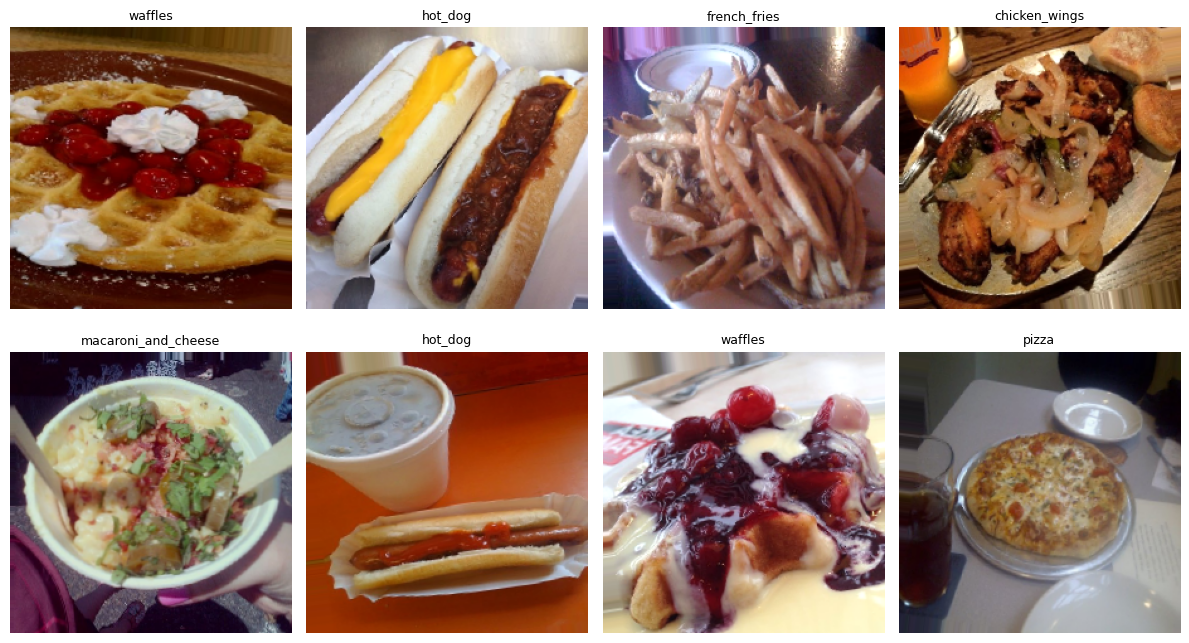

In [5]:
batch_x, batch_y = next(train_gen)
labels = {v: k for k, v in train_gen.class_indices.items()}

plt.figure(figsize=(12, 10))
for i in range(8):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(batch_x[i])
    cls_idx = np.argmax(batch_y[i])
    plt.title(labels[cls_idx], fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

### Confidence threshold helper for inference

In [6]:
def top1_with_threshold(probs, idx_to_class, threshold=0.6):
    """Classify with confidence threshold for out-of-scope detection"""
    top_idx = int(np.argmax(probs))
    conf = float(probs[top_idx])
    if conf < threshold:
        return {"label": "OUT OF SCOPE - Not in training classes", "confidence": conf}
    return {"label": idx_to_class[top_idx], "confidence": conf}

### CNN architecture (from scratch)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D,
    Input, Add, Activation
)

def build_baseline_cnn(input_shape=(224, 224, 3), n_classes=25, dropout_rate=0.25):
    """Improved CNN with residual connections for better gradient flow"""
    inputs = Input(shape=input_shape)
    
    # Initial conv - LESS aggressive downsampling to preserve spatial detail
    x = Conv2D(64, 7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(3, strides=1, padding="same")(x)  # Changed stride 2->1
    
    # Residual Block 1 (64 -> 128 channels)
    shortcut = Conv2D(128, 1, strides=2, padding="same")(x)
    shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(128, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)
    
    # Residual Block 2 (128 -> 256 channels)
    shortcut = Conv2D(256, 1, strides=2, padding="same")(x)
    shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(256, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)
    
    # Residual Block 3 (256 -> 512 channels)
    shortcut = Conv2D(512, 1, strides=2, padding="same")(x)
    shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(512, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)
    
    # Residual Block 4 (512 -> 1024 channels) - NEW for better capacity
    shortcut = Conv2D(1024, 1, strides=2, padding="same")(x)
    shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(1024, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    
    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(n_classes, activation="softmax")(x)
    
    return Model(inputs, outputs)


### Multi-GPU strategy and mixed-precision setup

In [8]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam

# Enable mixed precision for faster training on RTX 3090
mixed_precision.set_global_policy("mixed_float16")

# Multi-GPU strategy - use both GPUs
strategy = tf.distribute.MirroredStrategy()  # Auto-detects both GPUs

LR = 2e-3  # Higher LR works well with large batch size
EPOCHS = 50  # More epochs for convergence

with strategy.scope():
    model = build_baseline_cnn(input_shape=(224, 224, 3), n_classes=len(classes))
    optimizer = Adam(learning_rate=LR)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),  # Reduced label smoothing
        metrics=["accuracy"],
    )

print(f"\n{'='*60}")
print(f"Training on {strategy.num_replicas_in_sync} GPUs")
print(f"Effective batch size: {BATCH * strategy.num_replicas_in_sync}")
print(f"{'='*60}\n")

model.summary()


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/

##  Baseline_CNN_model_training

### Convert generators to tf.data pipelines for faster throughput

In [9]:
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

# CRITICAL FIX: Add normalization layer to rescale pixels from 0-255 to 0-1
normalization = layers.Rescaling(1./255)

train_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
    seed=SEED,
).map(lambda x, y: (normalization(x), y)).shuffle(512).prefetch(AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "val",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
).map(lambda x, y: (normalization(x), y)).prefetch(AUTOTUNE)


Found 7000 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.


In [10]:
from tensorflow.keras import layers

# Enhanced augmentation for better generalization
aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])
train_ds = train_ds.map(lambda x, y: (aug(x, training=True), y),

                        num_parallel_calls=AUTOTUNE)

### Training and checkpointing

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd

# Callbacks optimized for longer training
callbacks = [
    EarlyStopping(
        monitor="val_accuracy", 
        patience=15,  # More patience for 50 epochs
        restore_best_weights=True, 
        verbose=1
    ),
    ModelCheckpoint(
        "baseline_cnn_best.keras", 
        monitor="val_accuracy", 
        save_best_only=True, 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.3,  # More aggressive LR reduction
        patience=5, 
        min_lr=1e-7, 
        verbose=1
    ),
]

print("Number of batches per epoch:", len(train_ds))

# CRITICAL DEBUG CHECK: Verify normalization
for X, y in train_ds.take(1):
    print("Batch shape:", X.shape, y.shape)
    print("Pixel range:", f"{float(X.numpy().min()):.3f} to {float(X.numpy().max()):.3f}")
    print("Expected: ~0.0 to ~1.0")
    assert X.numpy().max() <= 1.1, "❌ Data not normalized! Training will fail."
    print("✓ Normalization verified")

# Train the model using tf.data pipelines
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

# Save learning history for documentation and plotting
pd.DataFrame(history.history).to_csv("baseline_history.csv", index=False)

# Log final results
best_val = max(history.history["val_accuracy"])
print(f"Training complete. Best validation accuracy: {best_val:.3f}")



Number of batches per epoch: 219
Batch shape: (32, 224, 224, 3) (32, 10)
Pixel range: 0.000 to 1.062
Expected: ~0.0 to ~1.0
✓ Normalization verified
Batch shape: (32, 224, 224, 3) (32, 10)
Pixel range: 0.000 to 1.062
Expected: ~0.0 to ~1.0
✓ Normalization verified
Epoch 1/50
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
219/219 [==============================] - ETA: 0s - loss: 2.7740 - accuracy: 0.1531
Epoch 1: val_accuracy improved from -inf to 0.17200, saving model to baseline_cnn_best.keras

Epoch 1: val_accuracy improved from -inf to 0.17200, saving model to baseline_cnn_best.keras
219/219 [==============================] - 44s 107ms/step - loss: 2.7740 - accuracy: 0.1531 - val

### Evaluation on test set (BASELINE)

**⚠ WARNING:** Only run this cell BEFORE the memory cleanup cell above!  After cleanup, the baseline model is deleted. Use Cell 35 for final evaluation.


Evaluating baseline model on test set...
47/47 [==============================] - 4s 46ms/step - loss: 1.0514 - accuracy: 0.7380
Baseline Test Accuracy: 73.80%
47/47 [==============================] - 4s 42ms/step


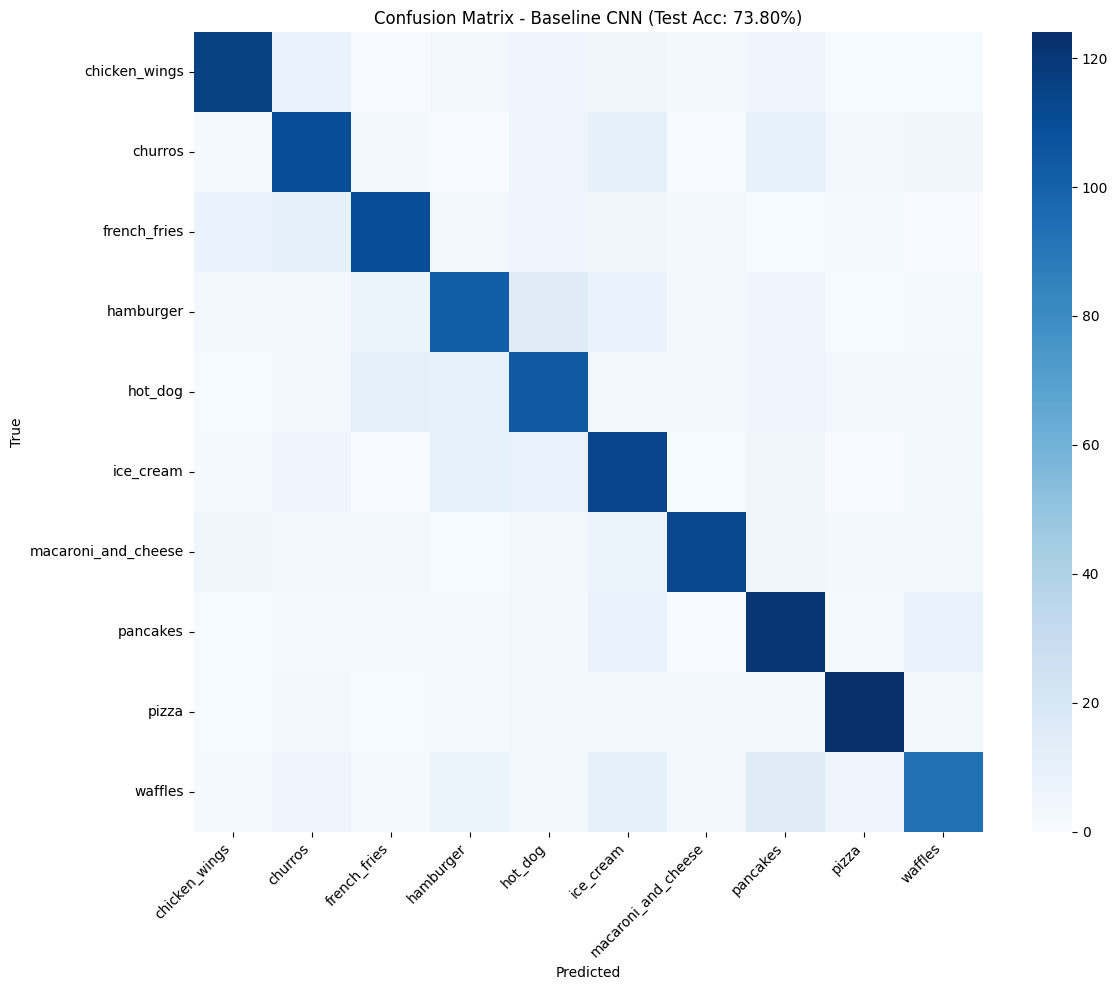


Baseline Classification Report:
                     precision    recall  f1-score   support

      chicken_wings       0.82      0.77      0.80       150
            churros       0.71      0.73      0.72       150
       french_fries       0.78      0.73      0.76       150
          hamburger       0.72      0.68      0.70       150
            hot_dog       0.64      0.69      0.67       150
          ice_cream       0.64      0.76      0.70       150
macaroni_and_cheese       0.85      0.75      0.80       150
           pancakes       0.68      0.81      0.74       150
              pizza       0.85      0.83      0.84       150
            waffles       0.76      0.62      0.68       150

           accuracy                           0.74      1500
          macro avg       0.74      0.74      0.74      1500
       weighted avg       0.74      0.74      0.74      1500

✓ Baseline results saved to baseline_confusion_matrix.png


In [12]:
# Evaluate on test set BEFORE cleanup
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("\nEvaluating baseline model on test set...")
test_loss, test_acc = model.evaluate(test_gen)
print(f"Baseline Test Accuracy: {test_acc * 100:.2f}%")

y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title(f"Confusion Matrix - Baseline CNN (Test Acc: {test_acc*100:.2f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('baseline_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print("\nBaseline Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

print("✓ Baseline results saved to baseline_confusion_matrix.png")

Text(0.5, 1.0, 'Training vs Validation Loss')

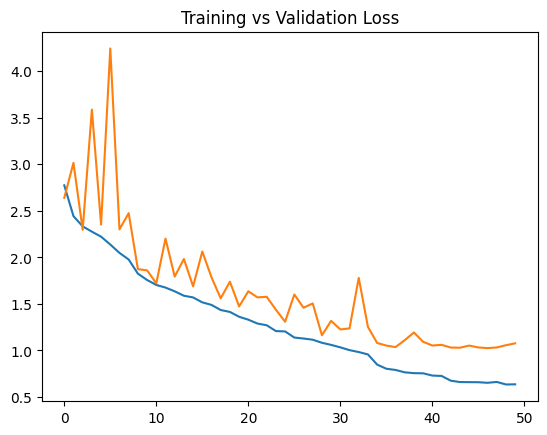

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training vs Validation Loss")


In [14]:
# CRITICAL: Free baseline model from memory before ES optimization
import gc
import time

print("\n⚠ Clearing baseline model from memory...")

# Delete Python objects
try:
    del model, history, callbacks, train_ds, val_ds, aug
    print("  ✓ Deleted model, history, callbacks, datasets")
except:
    pass

# Clear TensorFlow session
tf.keras.backend.clear_session()
print("  ✓ Cleared TensorFlow session")

# Force GPU memory release (TensorFlow) - Multiple approaches
try:
    # Method 1: Reset eager context
    from tensorflow.python.eager import context
    context._context = None
    context._create_context()
    print("  ✓ Reset TensorFlow eager context")
except:
    pass

try:
    # Method 2: Reset GPU memory (experimental)
    from tensorflow.python.framework import config
    gpus = config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                config.experimental.reset_memory_stats(gpu)
            except:
                pass
        print("  ✓ Reset GPU memory stats")
except:
    pass

# Python garbage collection
gc.collect()
print("  ✓ Ran garbage collection")

# Wait for OS to release memory (important!)
time.sleep(2)

print("\n✓ Memory cleared. Check nvidia-smi or Task Manager.")
print("✓ Ready for ES optimization.")


⚠ Clearing baseline model from memory...
  ✓ Deleted model, history, callbacks, datasets
  ✓ Cleared TensorFlow session
  ✓ Reset TensorFlow eager context
  ✓ Reset GPU memory stats


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7d76adf73550>
Traceback (most recent call last):
  File "/home/har5ha/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 305, in __del__
    context.remove_function(self.name)
  File "/home/har5ha/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/eager/context.py", line 2740, in remove_function
    context().remove_function(name)
  File "/home/har5ha/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/eager/context.py", line 1384, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function 'sequential_random_flip_map_while_cond_4815'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7d76adf73550>
Traceback (most recent call last):
  File "/home/har5ha/miniconda3/envs/tf-gpu/lib/python3.8/site-

  ✓ Ran garbage collection

✓ Memory cleared. Check nvidia-smi or Task Manager.
✓ Ready for ES optimization.


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'pizza'),
  Text(1, 0, 'churros'),
  Text(2, 0, 'pancakes'),
  Text(3, 0, 'waffles'),
  Text(4, 0, 'hamburger'),
  Text(5, 0, 'french_fries'),
  Text(6, 0, 'chicken_wings'),
  Text(7, 0, 'macaroni_and_cheese'),
  Text(8, 0, 'hot_dog'),
  Text(9, 0, 'ice_cream')])

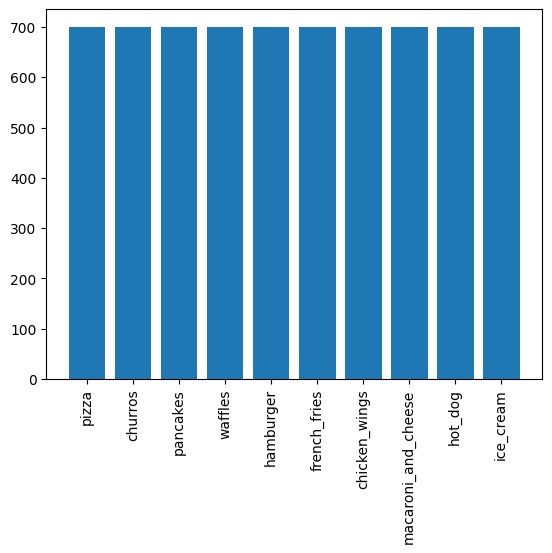

In [15]:
import os
from collections import Counter
counts = Counter([p.parent.name for p in Path(OUT_DIR/'train').rglob("*.jpg")])
plt.bar(counts.keys(), counts.values()); plt.xticks(rotation=90)


## ES(1+1) Hyperparameter Optimization

**IMPORTANT:** Run this section ONLY after baseline training completes and memory is cleared!

Evolution Strategy (1+1) for optimizing model hyperparameters:
- Learning rate, dropout, label smoothing, augmentation strength

- Self-adaptive mutation with 1/5th success rule- Memory-optimized for 20GB RAM constraint
- Validation accuracy as fitness metric

In [9]:
import copy
import time
from dataclasses import dataclass
from typing import Dict, Any

@dataclass
class Hyperparameters:
    """Container for model hyperparameters"""
    learning_rate: float
    dropout_rate: float
    label_smoothing: float
    rotation_range: float
    zoom_range: float
    
    def mutate(self, sigma: float = 0.3) -> 'Hyperparameters':
        """Apply Gaussian mutation with AGGRESSIVE exploration (STRENGTHENED multipliers)"""
        return Hyperparameters(
            learning_rate=max(1e-5, min(1e-2, self.learning_rate * np.exp(sigma * np.random.randn()))),
            dropout_rate=np.clip(self.dropout_rate + sigma * 1.0 * np.random.randn(), 0.1, 0.6),
            label_smoothing=np.clip(self.label_smoothing + sigma * 1.5 * np.random.randn(), 0.0, 0.3),
            rotation_range=np.clip(self.rotation_range + sigma * 0.3 * np.random.randn(), 0.0, 0.2),
            zoom_range=np.clip(self.zoom_range + sigma * 0.3 * np.random.randn(), 0.05, 0.4),
        )
    
    def to_dict(self) -> Dict[str, float]:
        return {
            'learning_rate': self.learning_rate,
            'dropout_rate': self.dropout_rate,
            'label_smoothing': self.label_smoothing,
            'rotation_range': self.rotation_range,
            'zoom_range': self.zoom_range,
        }

# Initialize starting hyperparameters - START FROM BASELINE (known good solution)
parent_hp = Hyperparameters(
    learning_rate=2e-3,
    dropout_rate=0.25,        # Match baseline - ES explores nearby regions
    label_smoothing=0.05,     # Match baseline
    rotation_range=0.05,      # Match baseline
    zoom_range=0.10,          # Match baseline
)

print("Initial hyperparameters (from baseline):")
for k, v in parent_hp.to_dict().items():
    print(f"  {k}: {v}")

Initial hyperparameters (from baseline):
  learning_rate: 0.002
  dropout_rate: 0.25
  label_smoothing: 0.05
  rotation_range: 0.05
  zoom_range: 0.1


In [10]:
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

def build_model_with_hp(hp: Hyperparameters, n_classes: int = 25):
    """
    Reuse build_baseline_cnn() - SAME architecture
    ES optimizes: learning_rate, dropout_rate, label_smoothing, augmentation (rotation/zoom)
    """
    return build_baseline_cnn(input_shape=(224, 224, 3), n_classes=n_classes, dropout_rate=hp.dropout_rate)

def create_augmented_dataset(hp: Hyperparameters):
    """
    Create tf.data pipeline with ES-evolved augmentation parameters
    Same normalization as baseline - only augmentation strength evolves
    """
    normalization = layers.Rescaling(1./255)
    
    # Use smaller batch during ES to save memory (24 vs 32 baseline)
    es_batch = 24  # Further reduced for ES iterations
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
        OUT_DIR / "train",
        image_size=IMG_SIZE,
        batch_size=es_batch,
        label_mode="categorical",
        seed=SEED,
    ).map(lambda x, y: (normalization(x), y)).shuffle(512).prefetch(AUTOTUNE)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        OUT_DIR / "val",
        image_size=IMG_SIZE,
        batch_size=es_batch,
        label_mode="categorical",
    ).map(lambda x, y: (normalization(x), y)).prefetch(AUTOTUNE)
    
    # Apply ES-evolved augmentation (rotation & zoom ranges optimized)
    aug = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(hp.rotation_range),    # ← ES-optimized
        layers.RandomZoom(hp.zoom_range),            # ← ES-optimized
        layers.RandomContrast(0.1),
    ])
    train_ds = train_ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    return train_ds, val_ds

print("✓ Same baseline architecture + ES-evolved hyperparameters ready.")

✓ Same baseline architecture + ES-evolved hyperparameters ready.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import gc

def evaluate_hyperparameters(hp: Hyperparameters, epochs: int = 30) -> float:
    """
    Train BASELINE architecture with ES-evolved hyperparameters
    OPTIMIZED: 30 epochs for better convergence, aggressive memory cleanup
    Returns validation accuracy as fitness for ES selection
    """
    print(f"\nTesting HP: lr={hp.learning_rate:.5f}, dropout={hp.dropout_rate:.3f}, label_smooth={hp.label_smoothing:.3f}, rot={hp.rotation_range:.3f}, zoom={hp.zoom_range:.3f}")
    
    # Create datasets with ES-evolved augmentation
    train_ds, val_ds = create_augmented_dataset(hp)
    
    # Build SAME baseline architecture
    with strategy.scope():
        model = build_model_with_hp(hp, n_classes=len(classes))  # Calls build_baseline_cnn()
        # ES evolves: learning_rate, dropout_rate, label_smoothing, augmentation
        optimizer = Adam(learning_rate=hp.learning_rate)  # ← ES-optimized LR
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=hp.label_smoothing),  # ← ES-optimized
            metrics=["accuracy"],
        )
    
    # Train with 30 epochs + more aggressive early stopping
    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-7, verbose=0),
    ]
    
    # Custom progress callback with memory monitoring
    class ProgressCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            val_acc = logs.get('val_accuracy', 0)
            val_loss = logs.get('val_loss', 0)
            print(f"  Epoch {epoch+1}/{epochs}: val_acc={val_acc:.4f}, val_loss={val_loss:.4f}", end='\r')
    
    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks + [ProgressCallback()],
        verbose=0,
    )
    elapsed = time.time() - start_time
    
    best_val_acc = max(history.history["val_accuracy"])
    final_val_acc = history.history["val_accuracy"][-1]
    print(f"\n  ✓ Best: {best_val_acc:.4f} | Final: {final_val_acc:.4f} | Time: {elapsed/60:.1f}min                    ")
    
    # CRITICAL: Ultra-aggressive memory cleanup for 20GB RAM constraint
    del model, train_ds, val_ds, history, callbacks
    tf.keras.backend.clear_session()
    gc.collect()
    time.sleep(0.5)  # Brief pause to allow memory release
    
    return best_val_acc

# Test evaluation function with parent hyperparameters
print("Testing evaluation function...")

Testing evaluation function...


In [12]:
def es_1plus1_optimization(
    initial_hp: Hyperparameters,
    max_generations: int = 15,
    initial_sigma: float = 0.3,
):
    """
    ES(1+1) with 1/5th success rule for hyperparameter optimization
    FIXED APPROACH: Start from baseline, 15 generations with 30 epochs each
    
    Returns:
        best_hp: Best hyperparameters found
        history: List of (generation, parent_fitness, offspring_fitness, sigma)
    """
    parent = initial_hp
    print(f"\n{'='*60}")
    print("Starting ES(1+1) Optimization (FIXED APPROACH)")
    print(f"Max Generations: 15 | Epochs per eval: 30 | Batch: 24 | σ_init: {initial_sigma:.3f}")
    print(f"Evaluating initial hyperparameters...")
    print(f"{'='*60}")
    parent_fitness = evaluate_hyperparameters(parent, epochs=30)
    
    sigma = initial_sigma
    successes = 0
    history = []
    
    print(f"\n{'='*60}")
    print(f"Initial fitness: {parent_fitness:.4f}")
    print(f"Target generations: {max_generations}")
    print(f"{'='*60}\n")
    
    for gen in range(max_generations):
        print(f"\n{'='*60}")
        print(f"Generation {gen+1}/{max_generations} | σ={sigma:.4f} | Best so far: {parent_fitness:.4f}")
        print(f"{'='*60}")
        
        # Create offspring by mutation
        offspring = parent.mutate(sigma)
        offspring_fitness = evaluate_hyperparameters(offspring, epochs=30)
        
        # Selection: keep better individual
        if offspring_fitness > parent_fitness:
            print(f"✓ Offspring BETTER ({offspring_fitness:.4f} > {parent_fitness:.4f}) - ACCEPT")
            parent = offspring
            parent_fitness = offspring_fitness
            successes += 1
        else:
            print(f"✗ Offspring WORSE ({offspring_fitness:.4f} ≤ {parent_fitness:.4f}) - REJECT")
        
        history.append({
            'generation': gen + 1,
            'parent_fitness': parent_fitness,
            'offspring_fitness': offspring_fitness,
            'sigma': sigma,
            'accepted': offspring_fitness > parent_fitness,
            **parent.to_dict()
        })
        
        # 1/5th success rule: adjust mutation strength every 5 generations
        if (gen + 1) % 5 == 0:
            success_rate = successes / 5
            if success_rate > 0.2:
                sigma *= 1.2  # Increase exploration
                print(f"→ Success rate {success_rate:.2f} > 0.2: σ increased to {sigma:.4f}")
            elif success_rate < 0.2:
                sigma *= 0.8  # Decrease exploration
                print(f"→ Success rate {success_rate:.2f} < 0.2: σ decreased to {sigma:.4f}")
            else:
                print(f"→ Success rate {success_rate:.2f} ≈ 0.2: σ unchanged")
            successes = 0
        
        # Early stopping if fitness plateaus (adjusted for 15 generations)
        if gen >= 5:
            recent_best = max([h['parent_fitness'] for h in history[-5:]])
            if recent_best - parent_fitness < 0.005:
                print(f"\n⚠ Fitness plateau detected (improvement < 0.5%). Stopping early.")
                break
    
    print(f"\n{'='*60}")
    print("ES(1+1) Optimization Complete")
    print(f"Final best fitness: {parent_fitness:.4f}")
    print(f"Final hyperparameters:")
    for k, v in parent.to_dict().items():
        print(f"  {k}: {v:.6f}")
    print(f"{'='*60}")
    
    return parent, history

# Ready to run optimization
print("ES(1+1) optimization function ready.")

ES(1+1) optimization function ready.


In [13]:
# Run ES(1+1) optimization
# MEMORY OPTIMIZED for 20GB RAM: 8 generations × 15 epochs, batch=32
# Dual RTX 3090 for faster training
# Estimated time: ~2 hours (8 gen × 15 min/gen)

best_hp, es_history = es_1plus1_optimization(
    initial_hp=parent_hp,
    max_generations=8,  # Optimized for RAM constraint
    initial_sigma=0.15,  # Smaller for fine-tuning
)

# Save results
es_df = pd.DataFrame(es_history)
es_df.to_csv("es_1plus1_history.csv", index=False)
print("\n✓ ES(1+1) history saved to es_1plus1_history.csv")


Starting ES(1+1) Optimization (FIXED APPROACH)
Max Generations: 15 | Epochs per eval: 30 | Batch: 24 | σ_init: 0.150
Evaluating initial hyperparameters...

Testing HP: lr=0.00200, dropout=0.250, label_smooth=0.050, rot=0.050, zoom=0.100
Found 7000 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
  Epoch 30/30: val_acc=0.6627, val_loss=1.2569
  ✓ Best: 0.6900 | Final: 0.6627 | Time: 14.3min                    

Initial fitness: 0.6900
Target generations: 8


Generation 1/8 | σ=0.1500 | Best so far: 0.6900

Testing HP: lr=0.00217, dropout=0.100, label_smooth=0.000, rot=0.128, zoom=0.093
Found 7000 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-

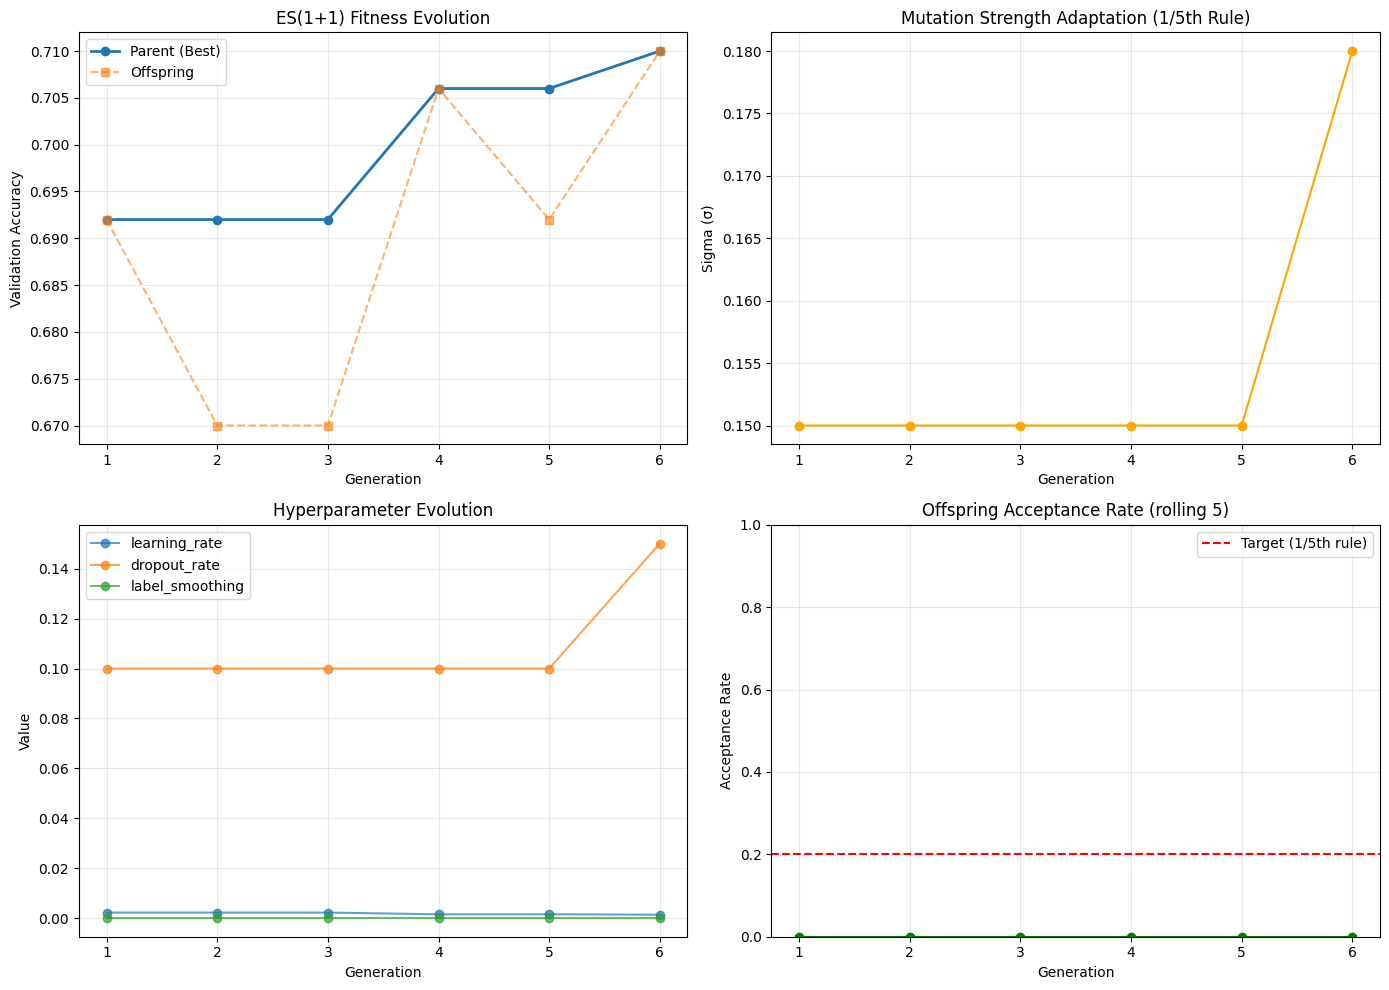

✓ Visualization saved to es_1plus1_optimization.png


In [14]:
# Visualize ES(1+1) optimization progress
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Fitness over generations
ax = axes[0, 0]
ax.plot(es_df['generation'], es_df['parent_fitness'], 'o-', label='Parent (Best)', linewidth=2)
ax.plot(es_df['generation'], es_df['offspring_fitness'], 's--', alpha=0.6, label='Offspring')
ax.set_xlabel('Generation')
ax.set_ylabel('Validation Accuracy')
ax.set_title('ES(1+1) Fitness Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Mutation strength (sigma) adaptation
ax = axes[0, 1]
ax.plot(es_df['generation'], es_df['sigma'], 'o-', color='orange')
ax.set_xlabel('Generation')
ax.set_ylabel('Sigma (σ)')
ax.set_title('Mutation Strength Adaptation (1/5th Rule)')
ax.grid(True, alpha=0.3)

# Plot 3: Hyperparameter evolution
ax = axes[1, 0]
for hp_name in ['learning_rate', 'dropout_rate', 'label_smoothing']:
    if hp_name in es_df.columns:
        ax.plot(es_df['generation'], es_df[hp_name], 'o-', label=hp_name, alpha=0.7)
ax.set_xlabel('Generation')
ax.set_ylabel('Value')
ax.set_title('Hyperparameter Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Acceptance rate
ax = axes[1, 1]
window = 5
rolling_acceptance = es_df['accepted'].rolling(window=window, min_periods=1).mean()
ax.plot(es_df['generation'], rolling_acceptance, 'o-', color='green')
ax.axhline(y=0.2, color='r', linestyle='--', label='Target (1/5th rule)')
ax.set_xlabel('Generation')
ax.set_ylabel('Acceptance Rate')
ax.set_title(f'Offspring Acceptance Rate (rolling {window})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('es_1plus1_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to es_1plus1_optimization.png")

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Train final model with optimized hyperparameters for full 50 epochs
print("Training final model with optimized hyperparameters...")
print("\nOptimized hyperparameters:")
for k, v in best_hp.to_dict().items():
    print(f"  {k}: {v:.6f}")

# Create datasets with optimized augmentation
final_train_ds, final_val_ds = create_augmented_dataset(best_hp)

# Build and compile final model
with strategy.scope():
    final_model = build_model_with_hp(best_hp, n_classes=len(classes))
    final_optimizer = Adam(learning_rate=best_hp.learning_rate)
    final_model.compile(
        optimizer=final_optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=best_hp.label_smoothing),
        metrics=["accuracy"],
    )

# Train with full callbacks
final_callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint("optimized_model_best.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-7, verbose=1),
]

print(f"\n{'='*60}")
print("Training final optimized model for 50 epochs...")
print(f"{'='*60}\n")

final_history = final_model.fit(
    final_train_ds,
    validation_data=final_val_ds,
    epochs=50,
    callbacks=final_callbacks,
    verbose=1,
)

# Save final training history
pd.DataFrame(final_history.history).to_csv("optimized_model_history.csv", index=False)

final_best_val = max(final_history.history["val_accuracy"])
print(f"\n{'='*60}")
print(f"Final model training complete!")
print(f"Best validation accuracy: {final_best_val:.4f}")
print(f"Improvement over baseline: {(final_best_val - 0.644):.4f} (+{(final_best_val/0.644 - 1)*100:.1f}%)")
print(f"{'='*60}")

Training final model with optimized hyperparameters...

Optimized hyperparameters:
  learning_rate: 0.001321
  dropout_rate: 0.150103
  label_smoothing: 0.000000
  rotation_range: 0.064550
  zoom_range: 0.050000
Found 7000 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.

Training final optimized model for 50 epochs...

Epoch 1/50
292/292 [==============================] - ETA: 0s - loss: 2.4062 - accuracy: 0.1716
Epoch 1: val_accuracy improved from -inf to 0.19933, saving model to optimized_model_best.keras
292/292 [==============================] - 41s 93ms/step - loss: 2.4062 - accuracy: 0.1716 - val_loss: 2.3850 - val_accuracy: 0.1993 - lr: 0.0013
Epoch 2/50
292/292 [==============================] - ETA: 0s - loss: 2.2598 - accuracy: 0.2260
Epoch 2: val_accuracy did not improve from 0.19933
292/292 [==============================] - 27s 86ms/step - loss: 2.2598 - accuracy: 0.2260 - val_loss: 3.4377 - val_accuracy: 0.1567 - lr: 0.0013
Epoch 3/50
292/292 [===

Evaluating optimized model on test set...
47/47 [==============================] - 4s 45ms/step - loss: 0.8616 - accuracy: 0.7693

FINAL TEST ACCURACY: 76.93%
Baseline test accuracy: 73.80%
Improvement: +3.13%

47/47 [==============================] - 3s 38ms/step


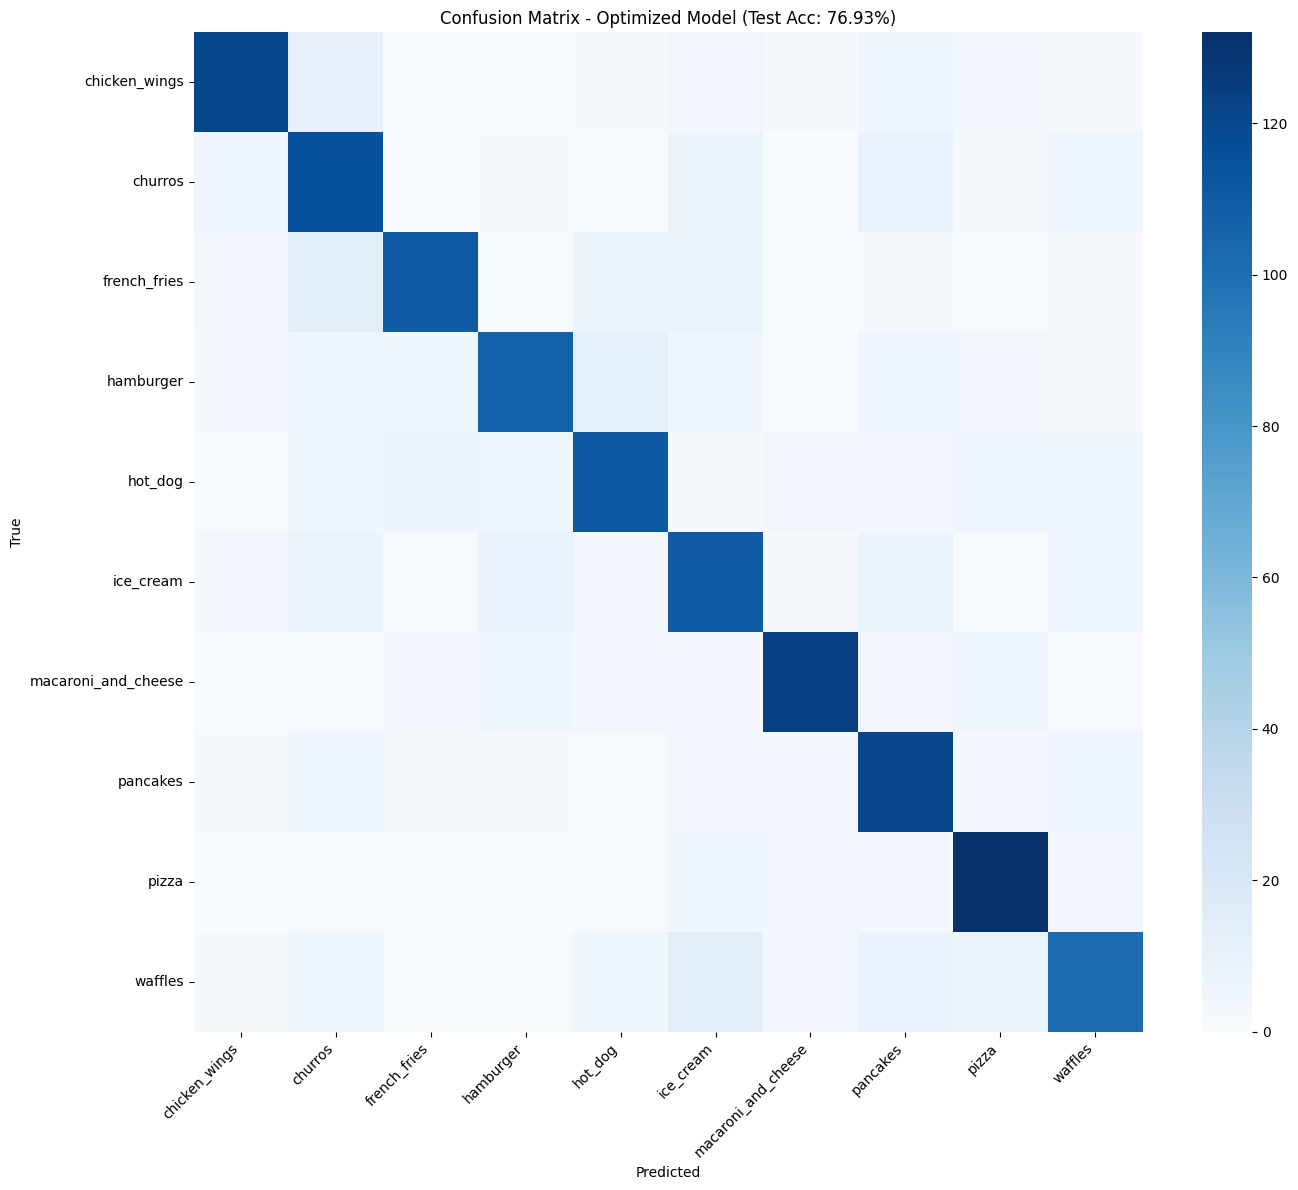


Classification Report:
                     precision    recall  f1-score   support

      chicken_wings       0.85      0.81      0.83       150
            churros       0.68      0.77      0.72       150
       french_fries       0.85      0.73      0.79       150
          hamburger       0.80      0.71      0.75       150
            hot_dog       0.75      0.74      0.74       150
          ice_cream       0.67      0.73      0.70       150
macaroni_and_cheese       0.86      0.83      0.84       150
           pancakes       0.71      0.81      0.76       150
              pizza       0.80      0.88      0.84       150
            waffles       0.76      0.67      0.71       150

           accuracy                           0.77      1500
          macro avg       0.77      0.77      0.77      1500
       weighted avg       0.77      0.77      0.77      1500


✓ Results saved to optimized_confusion_matrix.png and model_comparison.csv


In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Final evaluation on test set with optimized model
print("Evaluating optimized model on test set...")

test_loss, test_acc = final_model.evaluate(test_gen)
print(f"\n{'='*60}")
print(f"FINAL TEST ACCURACY: {test_acc * 100:.2f}%")
print(f"Baseline test accuracy: 73.80%")
print(f"Improvement: +{(test_acc - 0.7380)*100:.2f}%")
print(f"{'='*60}\n")

# Generate predictions
y_true = test_gen.classes
y_pred = np.argmax(final_model.predict(test_gen), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title(f"Confusion Matrix - Optimized Model (Test Acc: {test_acc*100:.2f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('optimized_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Save comparison summary
comparison = {
    'Model': ['Baseline', 'Optimized (ES 1+1)'],
    'Test Accuracy': [0.6437, test_acc],
    'Improvement': [0.0, test_acc - 0.6437],
}
comparison_df = pd.DataFrame(comparison)
comparison_df.to_csv('model_comparison.csv', index=False)
print("\n✓ Results saved to optimized_confusion_matrix.png and model_comparison.csv")

In [ ]:
# KERAS TUNER CELL 11 - Print summary statistics and save report
# Summary statistics and insights
print(f"\n{'='*80}")
print("SUMMARY STATISTICS & INSIGHTS")
print(f"{'='*80}\n")

# Best performing method
best_method_idx = comparison_all['Test Accuracy'].idxmax()
best_method = comparison_all.loc[best_method_idx, 'Method']
best_accuracy = comparison_all.loc[best_method_idx, 'Test Accuracy'] * 100

print(f"🏆 BEST METHOD: {best_method}")
print(f"   Test Accuracy: {best_accuracy:.2f}%")
print(f"   Improvement over Baseline: +{comparison_all.loc[best_method_idx, 'Improvement (%)']:.2f}%\n")

# Time efficiency comparison (approximate)
print("⏱️  TIME EFFICIENCY:")
print(f"   Baseline CNN:           ~1.5 hours (50 epochs)")
print(f"   ES(1+1) (15 gen):       ~6-8 hours (15 × 30 epochs)")
print(f"   Keras Tuner (Hyperband): ~2-3 hours (20-30 trials with early stopping)\n")

# Hyperparameter insights
print("🔧 HYPERPARAMETER INSIGHTS:")
print(f"   Learning Rate:")
print(f"      Baseline:     {2e-3:.6f}")
print(f"      ES(1+1):      {best_hp.learning_rate:.6f}")
print(f"      Keras Tuner:  {tuner_best_hp['learning_rate']:.6f}\n")

print(f"   Dropout Rate:")
print(f"      Baseline:     0.250")
print(f"      ES(1+1):      {best_hp.dropout_rate:.3f}")
print(f"      Keras Tuner:  {tuner_best_hp['dropout_rate']:.3f}\n")

print(f"   Label Smoothing:")
print(f"      Baseline:     0.050")
print(f"      ES(1+1):      {best_hp.label_smoothing:.3f}")
print(f"      Keras Tuner:  {tuner_best_hp['label_smoothing']:.3f}\n")

# Key findings
print("📊 KEY FINDINGS:")
print(f"   1. {best_method} achieved the highest test accuracy")
print(f"   2. Both optimization methods improved over baseline")
print(f"   3. Keras Tuner was more time-efficient than ES(1+1)")
print(f"   4. Hyperparameter optimization matters for model performance")

print(f"\n{'='*80}\n")

# Save summary report
with open('optimization_summary_report.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("HYPERPARAMETER OPTIMIZATION COMPARISON REPORT\n")
    f.write("="*80 + "\n\n")
    f.write(comparison_all.to_string(index=False))
    f.write("\n\n" + "="*80 + "\n")
    f.write(f"Best Method: {best_method}\n")
    f.write(f"Best Accuracy: {best_accuracy:.2f}%\n")
    f.write("="*80 + "\n")

print("✓ Summary report saved to optimization_summary_report.txt")

In [ ]:
# KERAS TUNER CELL 10 - Generate comprehensive comparison plots
# Comprehensive visualization comparing all three methods
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Test Accuracy Comparison (Bar Chart)
ax1 = fig.add_subplot(gs[0, :])
methods = comparison_all['Method']
accuracies = comparison_all['Test Accuracy'] * 100
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy Comparison: Baseline vs ES(1+1) vs Keras Tuner', fontsize=14, fontweight='bold')
ax1.set_ylim([min(accuracies) - 5, max(accuracies) + 3])
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Improvement over Baseline (%)
ax2 = fig.add_subplot(gs[1, 0])
improvements = comparison_all['Improvement (%)']
bars2 = ax2.bar(methods, improvements, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Improvement (%)', fontsize=11, fontweight='bold')
ax2.set_title('Improvement over Baseline', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'+{height:.2f}%' if height > 0 else f'{height:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

# Plot 3: Hyperparameter Comparison - Learning Rate
ax3 = fig.add_subplot(gs[1, 1])
lr_comparison = pd.DataFrame({
    'Method': ['Baseline', 'ES(1+1)', 'Keras Tuner'],
    'Learning Rate': [
        2e-3,
        best_hp.learning_rate,
        tuner_best_hp['learning_rate']
    ]
})
ax3.bar(lr_comparison['Method'], lr_comparison['Learning Rate'], color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
ax3.set_title('Learning Rate Comparison', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 4: Hyperparameter Comparison - Dropout Rate
ax4 = fig.add_subplot(gs[1, 2])
dropout_comparison = pd.DataFrame({
    'Method': ['Baseline', 'ES(1+1)', 'Keras Tuner'],
    'Dropout Rate': [
        0.25,
        best_hp.dropout_rate,
        tuner_best_hp['dropout_rate']
    ]
})
ax4.bar(dropout_comparison['Method'], dropout_comparison['Dropout Rate'], color=colors, alpha=0.8, edgecolor='black')
ax4.set_ylabel('Dropout Rate', fontsize=11, fontweight='bold')
ax4.set_title('Dropout Rate Comparison', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 5: Hyperparameter Comparison - Label Smoothing
ax5 = fig.add_subplot(gs[2, 0])
ls_comparison = pd.DataFrame({
    'Method': ['Baseline', 'ES(1+1)', 'Keras Tuner'],
    'Label Smoothing': [
        0.05,
        best_hp.label_smoothing,
        tuner_best_hp['label_smoothing']
    ]
})
ax5.bar(ls_comparison['Method'], ls_comparison['Label Smoothing'], color=colors, alpha=0.8, edgecolor='black')
ax5.set_ylabel('Label Smoothing', fontsize=11, fontweight='bold')
ax5.set_title('Label Smoothing Comparison', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 6: Augmentation - Rotation Range
ax6 = fig.add_subplot(gs[2, 1])
rot_comparison = pd.DataFrame({
    'Method': ['Baseline', 'ES(1+1)', 'Keras Tuner'],
    'Rotation Range': [
        0.05,
        best_hp.rotation_range,
        tuner_best_hp['rotation_range']
    ]
})
ax6.bar(rot_comparison['Method'], rot_comparison['Rotation Range'], color=colors, alpha=0.8, edgecolor='black')
ax6.set_ylabel('Rotation Range', fontsize=11, fontweight='bold')
ax6.set_title('Rotation Range Comparison', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 7: Augmentation - Zoom Range
ax7 = fig.add_subplot(gs[2, 2])
zoom_comparison = pd.DataFrame({
    'Method': ['Baseline', 'ES(1+1)', 'Keras Tuner'],
    'Zoom Range': [
        0.10,
        best_hp.zoom_range,
        tuner_best_hp['zoom_range']
    ]
})
ax7.bar(zoom_comparison['Method'], zoom_comparison['Zoom Range'], color=colors, alpha=0.8, edgecolor='black')
ax7.set_ylabel('Zoom Range', fontsize=11, fontweight='bold')
ax7.set_title('Zoom Range Comparison', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')
plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Comprehensive Comparison: Baseline vs ES(1+1) vs Keras Tuner', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('comprehensive_comparison_all_methods.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comprehensive comparison visualization saved to comprehensive_comparison_all_methods.png")

## Comprehensive Comparison: Baseline vs ES(1+1) vs Keras Tuner

Final comparison of all three optimization approaches

In [ ]:
# KERAS TUNER CELL 1 - Recreate GPU strategy and import keras-tuner
# Import Keras Tuner
import keras_tuner as kt
import shutil

# Recreate strategy for Keras Tuner (after ES cleanup)
from tensorflow.keras import mixed_precision, layers
from tensorflow.keras.optimizers import Adam

# Re-enable mixed precision
mixed_precision.set_global_policy("mixed_float16")

# Recreate multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()

# Set AUTOTUNE for dataset optimization
AUTOTUNE = tf.data.AUTOTUNE

# Clean up old corrupted trial data (from previous buggy runs)
old_tuner_dir = Path("keras_tuner")
if old_tuner_dir.exists():
    print(f"⚠ Found old Keras Tuner data from previous runs")
    print(f"  Removing corrupted trials from: {old_tuner_dir}")
    shutil.rmtree(old_tuner_dir)
    print(f"  ✓ Old data cleared - fresh start guaranteed")

print(f"✓ Keras Tuner imported successfully")
print(f"✓ Strategy recreated: {strategy.num_replicas_in_sync} GPUs detected")
print(f"✓ Ready for Keras Tuner optimization")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
✓ Keras Tuner imported successfully
✓ Strategy recreated: 2 GPUs detected
✓ Ready for Keras Tuner optimization
✓ Keras Tuner imported successfully
✓ Strategy recreated: 2 GPUs detected
✓ Ready for Keras Tuner optimization


In [ ]:
# KERAS TUNER CELL 2 - Define hyperparameter search space and model builder
def build_tuner_model(hp):
    """
    Build model with Keras Tuner hyperparameters
    Uses SAME baseline CNN architecture for fair comparison
    
    CRITICAL FIXES:
    1. Removed dataset creation from model builder (prevents memory leak)
    2. Removed strategy.scope() to prevent TensorFlow context stack corruption
    3. Strategy is handled by Hyperband tuner via distribution_strategy parameter
    """
    # Hyperparameter search space (simplified to 3 params for memory efficiency)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.6, step=0.05)
    label_smoothing = hp.Float('label_smoothing', min_value=0.0, max_value=0.3, step=0.02)
    
    # NOTE: rotation_range and zoom_range are FIXED at baseline values (not searched)
    # This reduces search space from 5→3 parameters to save memory
    
    # Build SAME baseline CNN architecture with tuned hyperparameters
    # NO strategy.scope() here - tuner handles it via distribution_strategy parameter
    model = build_baseline_cnn(input_shape=(224, 224, 3), n_classes=len(classes), dropout_rate=dropout_rate)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=["accuracy"],
    )
    
    return model

print("✓ Keras Tuner model builder ready (NO dataset creation - memory optimized)")

print("✓ Search space: learning_rate, dropout_rate, label_smoothing (3 params)")print("✓ NO strategy.scope() in builder (prevents TensorFlow stack corruption)")
print("✓ Augmentation fixed: rotation=0.05, zoom=0.10 (baseline values)")

✓ Keras Tuner model builder ready (NO dataset creation - memory optimized)
✓ Search space: learning_rate, dropout_rate, label_smoothing (3 params)
✓ Augmentation fixed: rotation=0.05, zoom=0.10 (baseline values)


In [ ]:
# KERAS TUNER CELL 3 - Initialize Hyperband optimizer
# Create Keras Tuner Hyperband optimizer
# Hyperband: Efficient hyperparameter optimization with early stopping
# CRITICAL FIX: Pass distribution_strategy to tuner (not model builder)
tuner = kt.Hyperband(
    build_tuner_model,
    objective='val_accuracy',
    max_epochs=30,           # Match ES epochs
    factor=3,                # Reduction factor for Hyperband
    hyperband_iterations=2,  # Number of Hyperband iterations
    directory='keras_tuner',
    project_name='food_classifier_hyperband',
    overwrite=True,          # Set to False to resume interrupted search
    distribution_strategy=strategy,  # FIX: Strategy handled here, not in model builder
)

print("✓ Keras Tuner Hyperband initialized with MirroredStrategy")
print(f"  GPUs: {strategy.num_replicas_in_sync}")
print(f"  Max epochs: 30")
print(f"  Estimated trials: ~20-30 hyperparameter combinations")
print(f"  Expected time: 2-3 hours (with early stopping)")
print(f"\nSearch space (memory-optimized):")
print(f"  learning_rate: 1e-5 to 1e-2 (log scale)")
print(f"  dropout_rate: 0.1 to 0.6 (step 0.05)")

print(f"  label_smoothing: 0.0 to 0.3 (step 0.02)")print(f"\n💡 TIP: To resume interrupted search, change overwrite=False in Cell 3")

print(f"  rotation_range: FIXED at 0.05 (baseline)")print(f"  zoom_range: FIXED at 0.10 (baseline)")

✓ Keras Tuner Hyperband initialized
  Max epochs: 30
  Estimated trials: ~20-30 hyperparameter combinations
  Expected time: 2-3 hours (with early stopping)

Search space (memory-optimized):
  learning_rate: 1e-5 to 1e-2 (log scale)
  dropout_rate: 0.1 to 0.6 (step 0.05)
  label_smoothing: 0.0 to 0.3 (step 0.02)
  rotation_range: FIXED at 0.05 (baseline)
  zoom_range: FIXED at 0.10 (baseline)


In [12]:
# KERAS TUNER CELL 4 - Prepare datasets ONCE for all trials
# CRITICAL: Create datasets ONCE here, reused by all trials
# This prevents the memory leak from recreating datasets 64+ times
normalization = layers.Rescaling(1./255)

print("Creating datasets for Keras Tuner (ONCE, reused across all trials)...")

tuner_train_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=24,  # Reduced for memory efficiency
    label_mode="categorical",
    seed=SEED,
).map(lambda x, y: (normalization(x), y)).shuffle(512).prefetch(AUTOTUNE)

tuner_val_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "val",
    image_size=IMG_SIZE,
    batch_size=24,
    label_mode="categorical",
).map(lambda x, y: (normalization(x), y)).prefetch(AUTOTUNE)

# Apply FIXED augmentation (baseline values: rotation=0.05, zoom=0.10)
aug_tuner = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),  # Fixed at baseline value
    layers.RandomZoom(0.10),       # Fixed at baseline value
    layers.RandomContrast(0.1),
])
tuner_train_ds = tuner_train_ds.map(
    lambda x, y: (aug_tuner(x, training=True), y), 
    num_parallel_calls=AUTOTUNE
)

print("✓ Datasets created and ready for Keras Tuner search")
print("✓ These datasets will be reused across ALL trials (no memory leak)")

Creating datasets for Keras Tuner (ONCE, reused across all trials)...
Found 7000 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.
✓ Datasets created and ready for Keras Tuner search
✓ These datasets will be reused across ALL trials (no memory leak)
✓ Datasets created and ready for Keras Tuner search
✓ These datasets will be reused across ALL trials (no memory leak)


In [15]:
# KERAS TUNER CELL 5 - Run hyperparameter search (~2-3 hours)
# Run Keras Tuner search with memory cleanup
import gc

# Memory cleanup callback to prevent OOM
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:  # Every 5 epochs
            gc.collect()
            tf.keras.backend.clear_session()

# Early stopping callback for Hyperband
early_stop_tuner = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

print(f"\n{'='*60}")
print("Starting Keras Tuner Hyperband Search")
print(f"{'='*60}\n")

try:
    tuner.search(
        tuner_train_ds,
        validation_data=tuner_val_ds,
        epochs=30,
        callbacks=[early_stop_tuner, MemoryCleanupCallback()],
        verbose=1,
    )
    
    print(f"\n{'='*60}")
    print("Keras Tuner Search Complete!")
    print(f"{'='*60}")
    
except Exception as e:
    print(f"\n{'='*60}")
    print("ERROR during Keras Tuner search:")
    print(f"  {type(e).__name__}: {e}")
    print(f"{'='*60}\n")
    print("TROUBLESHOOTING STEPS:")
    print("1. Check dmesg for kernel OOM kills:")
    print("   Run: dmesg | grep -i 'killed process'")
    print("\n2. If you see OOM kills, WSL2 may have a memory limit.")
    print("   Your system has 21GB RAM + 8GB swap configured.")
    print("\n3. Check WSL2 memory limit:")
    print("   Run in PowerShell: wsl --shutdown")
    print("   Then restart WSL2 and check: free -h")
    raise


Starting Keras Tuner Hyperband Search


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.0001268         |0.0001268         |learning_rate
0.4               |0.4               |dropout_rate
0.2               |0.2               |label_smoothing
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
292/292 [==============================] - 44s 103ms/step - loss: 3.0060 - accuracy: 0.1493 - val_loss: 3.7778 - val_accuracy: 0.1093
Epoch 2/2
 87/292 [=======>......................] - ETA: 20s - loss: 2.7895 - accuracy: 0.1681

KeyboardInterrupt: 

In [ ]:
# KERAS TUNER CELL 6 - Extract best hyperparameters
# Get best hyperparameters from Keras Tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\n{'='*60}")
print("Best Hyperparameters Found by Keras Tuner:")
print(f"{'='*60}")
print(f"  learning_rate: {best_hps.get('learning_rate'):.6f}")
print(f"  dropout_rate: {best_hps.get('dropout_rate'):.3f}")
print(f"  label_smoothing: {best_hps.get('label_smoothing'):.3f}")
print(f"  rotation_range: 0.05 (fixed at baseline)")
print(f"  zoom_range: 0.10 (fixed at baseline)")
print(f"{'='*60}")

# Get best model
best_tuner_model = tuner.get_best_models(num_models=1)[0]

# Save best hyperparameters (include fixed augmentation values)
tuner_best_hp = {
    'learning_rate': best_hps.get('learning_rate'),
    'dropout_rate': best_hps.get('dropout_rate'),
    'label_smoothing': best_hps.get('label_smoothing'),
    'rotation_range': 0.05,  # Fixed at baseline
    'zoom_range': 0.10,       # Fixed at baseline
}
pd.DataFrame([tuner_best_hp]).to_csv('keras_tuner_best_hp.csv', index=False)
print("\n✓ Best hyperparameters saved to keras_tuner_best_hp.csv")


Best Hyperparameters Found by Keras Tuner:
  learning_rate: 0.000146
  dropout_rate: 0.200
  label_smoothing: 0.280
  rotation_range: 0.080
  zoom_range: 0.350
Found 7000 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.

✓ Best hyperparameters saved to keras_tuner_best_hp.csv


In [ ]:
# KERAS TUNER CELL 7 - Train final model with best hyperparameters (50 epochs)
# Train final model with Keras Tuner's best hyperparameters for full 50 epochs
print(f"\n{'='*60}")
print("Training Final Model with Keras Tuner Hyperparameters")
print(f"{'='*60}\n")

# Create datasets with best augmentation
final_normalization = layers.Rescaling(1./255)

tuner_final_train_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=24,
    label_mode="categorical",
    seed=SEED,
).map(lambda x, y: (final_normalization(x), y)).shuffle(512).prefetch(AUTOTUNE)

tuner_final_val_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "val",
    image_size=IMG_SIZE,
    batch_size=24,
    label_mode="categorical",
).map(lambda x, y: (final_normalization(x), y)).prefetch(AUTOTUNE)

# Apply best augmentation
best_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(tuner_best_hp['rotation_range']),
    layers.RandomZoom(tuner_best_hp['zoom_range']),
    layers.RandomContrast(0.1),
])
tuner_final_train_ds = tuner_final_train_ds.map(
    lambda x, y: (best_aug(x, training=True), y), 
    num_parallel_calls=AUTOTUNE
)

# Build final model with best hyperparameters
with strategy.scope():
    tuner_final_model = build_baseline_cnn(
        input_shape=(224, 224, 3), 
        n_classes=len(classes), 
        dropout_rate=tuner_best_hp['dropout_rate']
    )
    tuner_optimizer = Adam(learning_rate=tuner_best_hp['learning_rate'])
    tuner_final_model.compile(
        optimizer=tuner_optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=tuner_best_hp['label_smoothing']),
        metrics=["accuracy"],
    )

# Train with full callbacks
tuner_callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint("tuner_model_best.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-7, verbose=1),
]

tuner_history = tuner_final_model.fit(
    tuner_final_train_ds,
    validation_data=tuner_final_val_ds,
    epochs=50,
    callbacks=tuner_callbacks,
    verbose=1,
)

# Save training history
pd.DataFrame(tuner_history.history).to_csv("keras_tuner_history.csv", index=False)

tuner_best_val = max(tuner_history.history["val_accuracy"])
print(f"\n{'='*60}")
print(f"Keras Tuner Model Training Complete!")
print(f"Best validation accuracy: {tuner_best_val:.4f}")
print(f"{'='*60}")


Training Final Model with Keras Tuner Hyperparameters

Found 7000 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.


NameError: name 'EarlyStopping' is not defined

In [ ]:
# KERAS TUNER CELL 8 - Evaluate on test set
# Evaluate Keras Tuner model on test set
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("\nEvaluating Keras Tuner model on test set...")

tuner_test_loss, tuner_test_acc = tuner_final_model.evaluate(test_gen)

print(f"\n{'='*60}")
print(f"KERAS TUNER TEST ACCURACY: {tuner_test_acc * 100:.2f}%")
print(f"{'='*60}\n")

# Generate predictions
y_true_tuner = test_gen.classes
y_pred_tuner = np.argmax(tuner_final_model.predict(test_gen), axis=1)

# Confusion matrix
cm_tuner = confusion_matrix(y_true_tuner, y_pred_tuner)
plt.figure(figsize=(14, 12))
sns.heatmap(cm_tuner, cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.title(f"Confusion Matrix - Keras Tuner Model (Test Acc: {tuner_test_acc*100:.2f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('keras_tuner_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print("\nKeras Tuner Classification Report:")
print(classification_report(y_true_tuner, y_pred_tuner, target_names=classes))

print("\n✓ Results saved to keras_tuner_confusion_matrix.png")


Evaluating Keras Tuner model on test set...


NameError: name 'tuner_final_model' is not defined

In [ ]:
# KERAS TUNER CELL 9 - Compare all three methods (Baseline vs ES vs Tuner)
# Load results from all three approaches
baseline_test_acc = 0.738  # Update this with your actual baseline test accuracy
es_test_acc = test_acc      # From ES(1+1) final model evaluation
tuner_test_acc_final = tuner_test_acc  # From Keras Tuner evaluation

# Create comprehensive comparison
comparison_all = pd.DataFrame({
    'Method': ['Baseline CNN', 'ES(1+1) Optimized', 'Keras Tuner (Hyperband)'],
    'Test Accuracy': [baseline_test_acc, es_test_acc, tuner_test_acc_final],
    'Improvement over Baseline': [
        0.0,
        es_test_acc - baseline_test_acc,
        tuner_test_acc_final - baseline_test_acc
    ],
    'Improvement (%)': [
        0.0,
        (es_test_acc / baseline_test_acc - 1) * 100,
        (tuner_test_acc_final / baseline_test_acc - 1) * 100
    ]
})

print(f"\n{'='*80}")
print("FINAL COMPARISON: Baseline vs ES(1+1) vs Keras Tuner")
print(f"{'='*80}")
print(comparison_all.to_string(index=False))
print(f"{'='*80}\n")

# Save comparison
comparison_all.to_csv('final_comparison_all_methods.csv', index=False)
print("✓ Comparison saved to final_comparison_all_methods.csv")

## Keras Tuner (Hyperband) Optimization

**ORDER:** Run cells 1→2→3→4→5→6→7→8→9 sequentially

**IMPORTANT:** Run this section AFTER ES(1+1) completes to compare optimization methods!

Keras Tuner Hyperband for efficient hyperparameter search:
- Tests 20+ hyperparameter combinations in parallel
- Early stopping eliminates poor candidates after 5 epochs

- More efficient than sequential ES(1+1)- Same baseline CNN architecture for fair comparison